My attempt at the dog-breed classifier from the **Stanford Dog Breed Dataset**.

Any advice to increase my model's accuracy much appreciated.
Each epoch takes around 350s to train even after applying transfer learning, any way to reduce this?
Let me know through the comments.

Please do up-vote if the notebook is useful to you or you fell it does a good job.

In [1]:
import os
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,GlobalAveragePooling2D,Dense,Flatten,Dropout
from keras.layers.normalization import BatchNormalization

In [2]:
#Importing the images

image_path = "/kaggle/input/stanford-dogs-dataset/images/Images/"

categories = os.listdir(image_path)
breeds=[]
for breed in categories:
    a=breed[10:]
    a=a.replace('_',' ')
    a=a.lower()
    breeds.append(a)
print("List of breeds = ",breeds[:20],"\n\nNo. of breeds = ", len(categories))

List of breeds =  ['chihuahua', 'basset', 'weimaraner', 'scottish deerhound', 'pug', 'entlebucher', 'dhole', 'african hunting dog', 'norfolk terrier', 'pembroke', 'blenheim spaniel', 'french bulldog', 'giant schnauzer', 'labrador retriever', 'soft-coated wheaten terrier', 'basenji', 'japanese spaniel', 'schipperke', 'english foxhound', 'toy terrier'] 

No. of breeds =  120


In [3]:
#Creating DataGenerators to get labels from image directories

from tensorflow.python.keras.preprocessing.image import ImageDataGenerator

image_size=224  #for the inception model

train_datagen=ImageDataGenerator(
                        rescale=1./255,
                        validation_split=0.2,
                        horizontal_flip=True,
                        width_shift_range=0.2,
                        height_shift_range=0.2,
                        shear_range=0.2,
                        rotation_range=40,
                        fill_mode='nearest'
                        )

train_generator=train_datagen.flow_from_directory(
                        image_path, 
                        target_size=(image_size,image_size),
                        subset='training',
                        shuffle=True,
                        batch_size=24,
                        class_mode='categorical'
                        )

valid_datagen=ImageDataGenerator(
                        validation_split=0.2,
                        rescale=1./255
                        )

valid_generator=valid_datagen.flow_from_directory(
                        image_path, 
                        target_size=(image_size,image_size),
                        subset='validation',
                        shuffle=False,
                        batch_size=24,
                        class_mode='categorical'
                        )

Found 16508 images belonging to 120 classes.
Found 4072 images belonging to 120 classes.


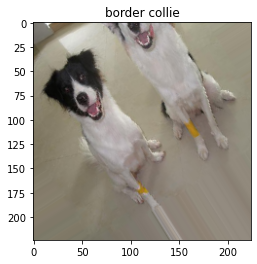

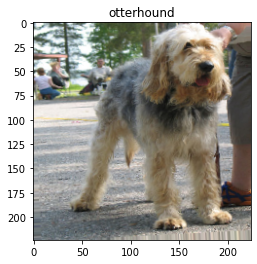

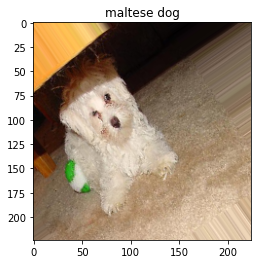

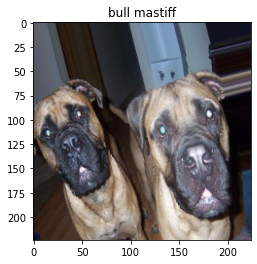

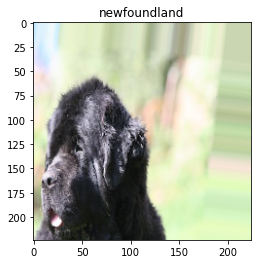

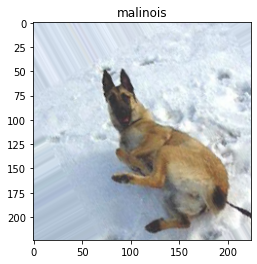

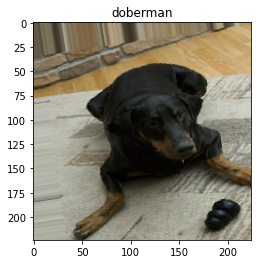

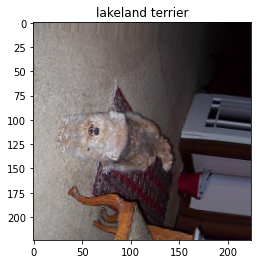

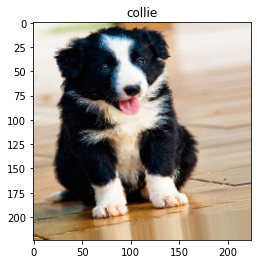

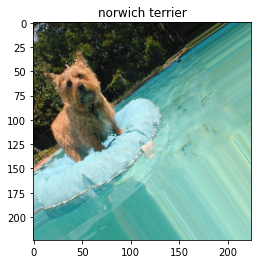

In [4]:
#Viewing some augmented images from the dataset with the correct label

x,y = train_generator.next()
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())

for i in range(0,10):
    image = x[i]
    plt.imshow(image)
    c=0
    for i in y[i]:
        if i==0:
            c+=1
        else:break
    label=labels[c][10:]
    label=label.replace('_',' ')
    label=label.lower()
    plt.title(label)
    plt.show()


In [5]:
#Applying transfer learning to build a model

from tensorflow.keras.applications.inception_v3 import InceptionV3

#using pre-trained weights for the inception model
local_weights_file = '../input/inception/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

Inception = InceptionV3(input_shape = (224,224,3), 
                                include_top = False, 
                                weights = local_weights_file)

#building a sequential model with inception layer base and only an average pooling layer before the output layer

model2=Sequential()
model2.add(Inception)
model2.add(Dropout(0.2))
model2.add(Dense(1024,activation='relu'))
model2.add(Dropout(0.2))
model2.add(Dense(1024,activation='relu'))
model2.add(Dropout(0.2))
model2.add(GlobalAveragePooling2D())
model2.add(Dense(512,activation='relu'))
model2.add(Dense(len(breeds),activation='softmax'))

model2.layers[0].trainable=False

model2.compile(optimizer='sgd',
             loss='categorical_crossentropy',
             metrics=['accuracy']
             )

model2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 5, 5, 2048)        21802784  
_________________________________________________________________
dropout (Dropout)            (None, 5, 5, 2048)        0         
_________________________________________________________________
dense (Dense)                (None, 5, 5, 1024)        2098176   
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 5, 1024)        0         
_________________________________________________________________
dense_1 (Dense)              (None, 5, 5, 1024)        1049600   
_________________________________________________________________
dropout_2 (Dropout)          (None, 5, 5, 1024)        0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0

In [6]:
#Training the model 
callback=tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=3,min_delta=0,mode='auto',restore_best_weights=False,baseline=None)

history=model2.fit_generator(train_generator,
                   steps_per_epoch=688,
                   epochs=20,
                   validation_data=valid_generator,
                   validation_steps=170,
                   callbacks=[callback])

Epoch 1/20
688/688 [==============================] - 385s 560ms/step - loss: 2.7340 - accuracy: 0.4099 - val_loss: 0.9129 - val_accuracy: 0.7485
Epoch 2/20
688/688 [==============================] - 345s 501ms/step - loss: 1.3130 - accuracy: 0.6404 - val_loss: 0.7832 - val_accuracy: 0.7706
Epoch 3/20
688/688 [==============================] - 345s 502ms/step - loss: 1.1613 - accuracy: 0.6702 - val_loss: 0.7326 - val_accuracy: 0.7800
Epoch 4/20
688/688 [==============================] - 344s 499ms/step - loss: 1.0949 - accuracy: 0.6856 - val_loss: 0.7107 - val_accuracy: 0.7881
Epoch 5/20
688/688 [==============================] - 343s 498ms/step - loss: 1.0534 - accuracy: 0.6980 - val_loss: 0.7089 - val_accuracy: 0.7844
Epoch 6/20
688/688 [==============================] - 342s 497ms/step - loss: 1.0301 - accuracy: 0.7034 - val_loss: 0.6923 - val_accuracy: 0.8001
Epoch 7/20
688/688 [==============================] - 342s 497ms/step - loss: 0.9954 - accuracy: 0.7105 - val_loss: 0.6989 -

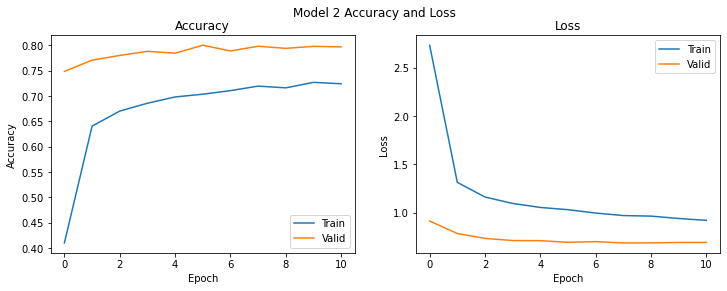

In [7]:
def plot_model(history):
    fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,4))
    fig.suptitle('Model 2 Accuracy and Loss')

    ax1.plot(history.history['accuracy'])
    ax1.plot(history.history['val_accuracy'])
    ax1.title.set_text('Accuracy')
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.legend(['Train','Valid'],loc=4)

    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.title.set_text('Loss')
    ax2.set_ylabel('Loss')
    ax2.set_xlabel('Epoch')
    ax2.legend(['Train','Valid'],loc=1)

    fig.show()

plot_model(history)

shih-tzu


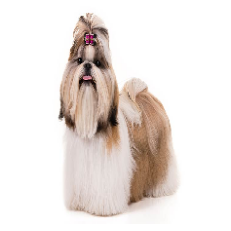

In [8]:
#Predicting a random image not present in the dataset

from cv2 import imread
from keras.applications.inception_v3 import preprocess_input

def predict(url, filename):
    # download and save
    os.system("curl -s {} -o {}".format(url, filename))
    img = Image.open(filename)
    img = img.convert('RGB')
    img = img.resize((image_size,image_size))
    img.save(filename)
    # show image
    plt.figure(figsize=(4, 4))
    plt.imshow(img)
    plt.axis('off')
    # predict
    img = imread(filename)
    img = preprocess_input(img)
    probs = model2.predict(np.expand_dims(img, axis=0))
    
    dict1={}
    for i,j in enumerate(probs[0]):
        dict1[i]=j
    
    a=max(dict1.keys(), key=(lambda k: dict1[k]))
    predicted_breed=labels[a][10:]
    predicted_breed=predicted_breed.replace('_',' ')
    predicted_breed=predicted_breed.lower()
    print(predicted_breed)
        
predict("https://s3.amazonaws.com/cdn-origin-etr.akc.org/wp-content/uploads/2017/11/12224329/Shih-Tzu-On-White-01.jpg",
                     "test_image_1.jpg")

In [9]:
from sklearn.metrics import classification_report

valid_generator.reset()
predictions=model2.predict_generator(valid_generator,steps=len(valid_generator))
y=np.argmax(predictions,axis=1)

print('Classification Report')
report=classification_report(y_true=valid_generator.classes,y_pred=y,target_names=valid_generator.class_indices)
print(report)

Classification Report
                                          precision    recall  f1-score   support

                     n02085620-Chihuahua       0.91      0.67      0.77        30
              n02085782-Japanese_spaniel       0.89      0.92      0.91        37
                   n02085936-Maltese_dog       0.75      0.86      0.80        50
                      n02086079-Pekinese       0.88      0.72      0.79        29
                      n02086240-Shih-Tzu       0.74      0.69      0.72        42
              n02086646-Blenheim_spaniel       0.92      0.89      0.90        37
                      n02086910-papillon       0.88      0.95      0.91        39
                   n02087046-toy_terrier       0.77      0.79      0.78        34
           n02087394-Rhodesian_ridgeback       0.88      0.65      0.75        34
                  n02088094-Afghan_hound       0.93      0.91      0.92        47
                        n02088238-basset       0.81      0.86      0.83    

Confusion Matrix


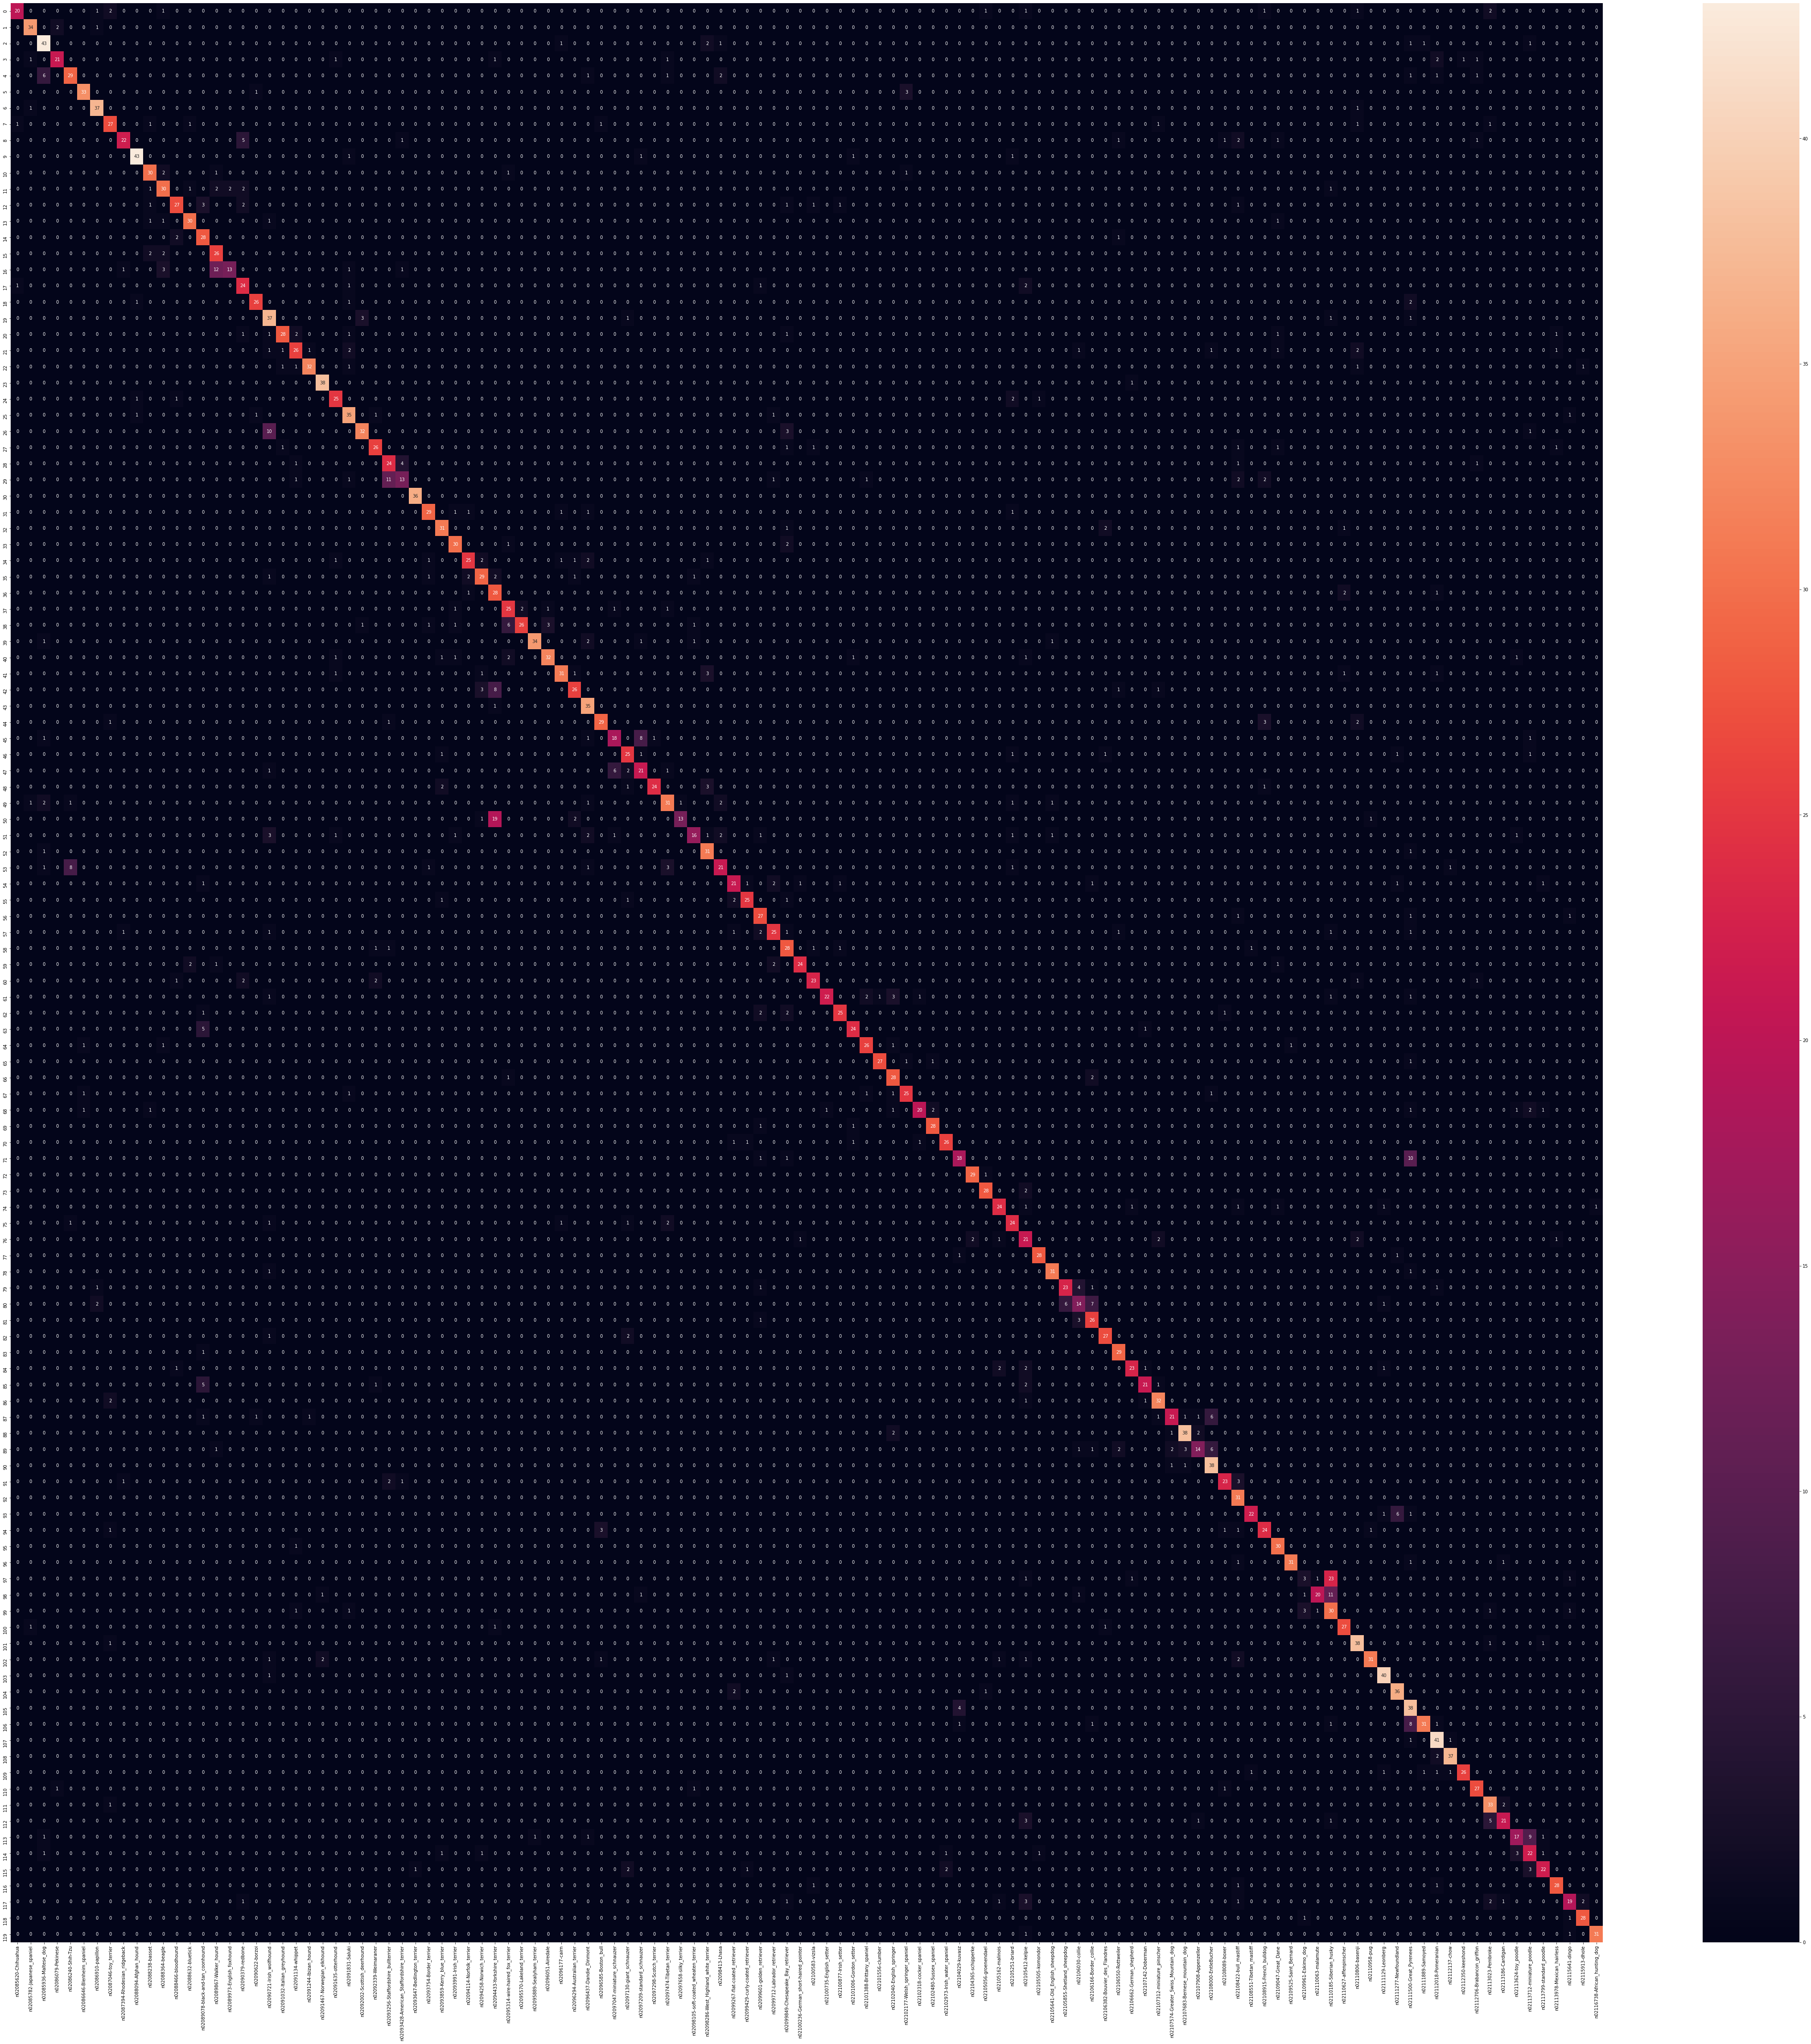

In [10]:
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix

print('Confusion Matrix')

cm=confusion_matrix(valid_generator.classes,y)
df=pd.DataFrame(cm,columns=valid_generator.class_indices)
plt.figure(figsize=(80,80))
sns.heatmap(df,annot=True)